# Evaluation on Synthetic Data

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import root_mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
import muvi

In [3]:
%matplotlib

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [4]:
# plotting settings
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("notebook")

Run a quick check if GPU(s) are available and select the least utilized GPU to perform the optimization.

In [5]:
device = "cpu"
try:
    device = f"cuda:{muvi.get_free_gpu_idx()}"
except Exception as e:
    print(e)

First, lets generate some multi-view synthetic data. The dataset comprises 200 samples and four views, each having 400 features. In addition, the underlying relationships across views consist of 2 factors shared among all views, 14 factors shared among a subset of two or three views, as well as a private factor for each view. Finally, we may introduce additional covariates that can be modelled jointly during training.

In [6]:
seed = 0
n_samples = 200
n_features = [400, 400, 400, 400]
n_views = len(n_features)
likelihoods = ["normal" for _ in range(n_views)]
n_covariates = 0

In [7]:
dg = muvi.DataGenerator(
    n_samples,
    n_features,
    likelihoods,
    n_covariates=n_covariates,
)

rng = dg.generate(seed=seed, all_combs=True)
rng = dg.generate_missingness(
    random_fraction=0.2,
    n_partial_samples=20,
    n_partial_features=50,
    missing_fraction_partial_features=0.5,
    seed=rng,
)

2025-11-21 19:50:06,714 - muvi.core.synthetic - WARNING - Using a uniform distribution with parameters 0.05 and 0.15 for generating the number of active factor loadings.
2025-11-21 19:50:06,716 - muvi.core.synthetic - WARNING - Generating all possible binary combinations of 4 variables.
2025-11-21 19:50:06,717 - muvi.core.synthetic - WARNING - New factor configuration: 1 fully shared, 10 partially shared, 4 private factors.


In [8]:
feature_offsets = [0] + np.cumsum(n_features).tolist()
vlines = feature_offsets[1:-1]

<Axes: >

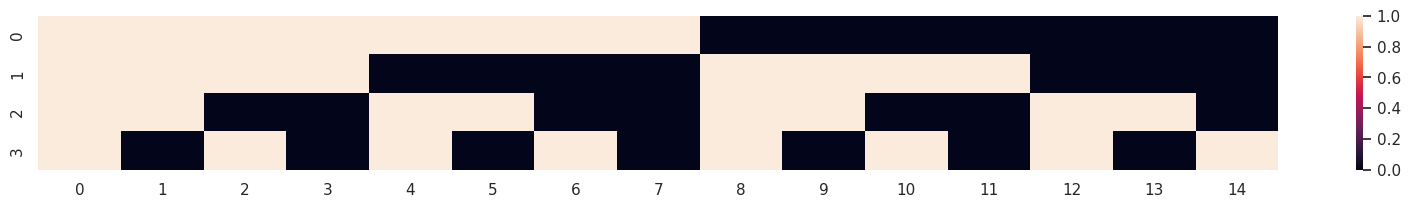

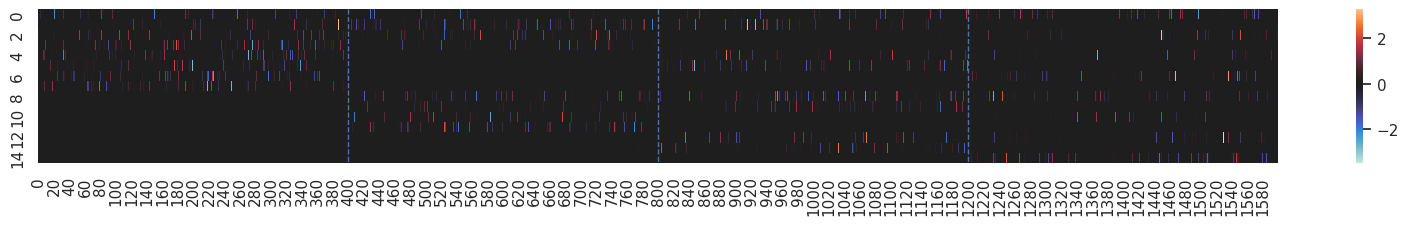

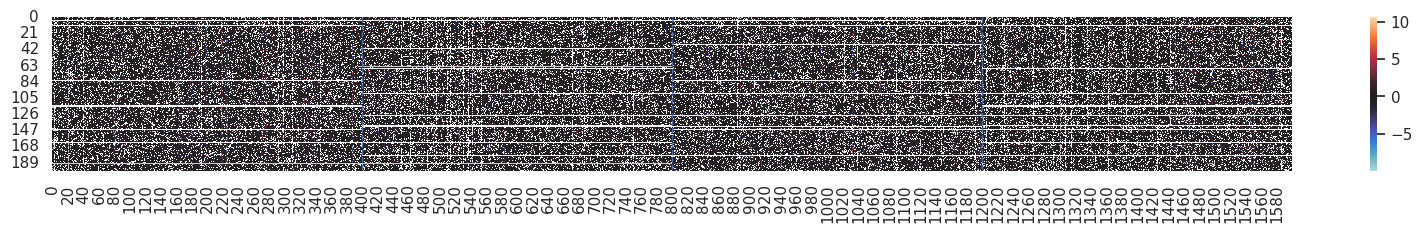

In [9]:
# factor loadings should be fairly sparse
muvi.pl.lined_heatmap(dg.view_factor_mask)
muvi.pl.lined_heatmap(dg.w, vlines=vlines, center=0)
muvi.pl.lined_heatmap(dg.missing_y, vlines=vlines, center=0)

Now we can perturb the true underlying mask of the factor loadings in order to inform the model noisy feature sets. We do so by introducing false positives and false negatives controlled by a `noise_fraction` parameter. We may also determine which views we would like to inform via `informed_views`, a list of view indices. Here we only inform the first view (index 0).

2025-11-21 19:50:08,990 - muvi.core.synthetic - WARNING - Factor 8 is completely off, inserting 9.97%% false positives.
2025-11-21 19:50:08,992 - muvi.core.synthetic - WARNING - Factor 9 is completely off, inserting 9.97%% false positives.
2025-11-21 19:50:08,995 - muvi.core.synthetic - WARNING - Factor 10 is completely off, inserting 9.97%% false positives.
2025-11-21 19:50:08,996 - muvi.core.synthetic - WARNING - Factor 11 is completely off, inserting 9.97%% false positives.
2025-11-21 19:50:08,997 - muvi.core.synthetic - WARNING - Factor 12 is completely off, inserting 9.97%% false positives.
2025-11-21 19:50:08,999 - muvi.core.synthetic - WARNING - Factor 13 is completely off, inserting 9.97%% false positives.
2025-11-21 19:50:09,000 - muvi.core.synthetic - WARNING - Factor 14 is completely off, inserting 9.97%% false positives.


<Axes: >

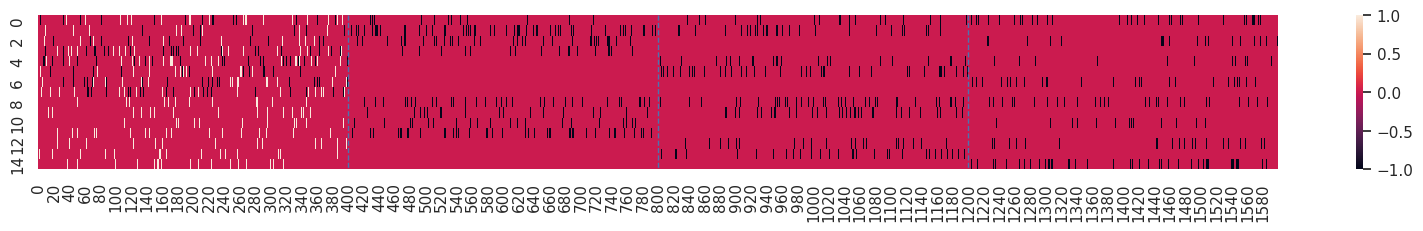

In [10]:
# perturb
noise_fraction = 0.5
# inform only first view with noisy prior
informed_views = [0]

_ = dg.get_noisy_mask(
    rng,
    noise_fraction=noise_fraction,
    informed_view_indices=informed_views,
)

# false positives and false negatives
muvi.pl.lined_heatmap(
    dg.noisy_w_mask.astype(int) - dg.w_mask.astype(int), vlines=vlines
)

Now that we generated a noisy version of the true factor loadings mask, we need to inform our model by relaxing the binary prior information to values larger than zero for the slab widths of the regularized horseshoe. We do so by providing a `prior_confidence` that ranges from 0 to 1 when adding the prior mask. The `prior_confidence` encodes our prior belief regarding the (noisy) prior information. A weak belief corresponds to values around 0.97, medium to 0.99 and strong to 0.995 or larger (closer to 1.0). As a rule of thumb, a `prior_confidence` of around 0.99 provides the best results on average. In this notebook we use a low `prior_confidence` of 0.97, as we have distorted the prior information quite severely, and we are informing only one out of four views.

In [11]:
# create an instance of the model
model = muvi.MuVI(
    dg.missing_ys,
    prior_masks=dg.noisy_w_masks,
    covariates=dg.x,
    prior_confidence=0.97,
    device=device,
)
model.factor_names = pd.Index([f"pathway_{i}" for i in range(model.n_factors)])
model

2025-11-21 19:50:09,735 - muvi.core.models - WARNING - No view names provided!
2025-11-21 19:50:09,736 - muvi.core.models - INFO - Setting the name of each view to `view_idx` for list observations.
2025-11-21 19:50:09,742 - muvi.core.models - INFO - Setting the name of each sample to `sample_idx`.
2025-11-21 19:50:09,744 - muvi.core.models - INFO - Setting the name of each feature in `view_0` to `view_0_feature_idx`.
2025-11-21 19:50:09,745 - muvi.core.models - INFO - Setting the name of each feature in `view_1` to `view_1_feature_idx`.
2025-11-21 19:50:09,746 - muvi.core.models - INFO - Setting the name of each feature in `view_2` to `view_2_feature_idx`.
2025-11-21 19:50:09,748 - muvi.core.models - INFO - Setting the name of each feature in `view_3` to `view_3_feature_idx`.
2025-11-21 19:50:09,753 - muvi.core.models - INFO - np.ndarray detected.
2025-11-21 19:50:09,754 - muvi.core.models - INFO - np.ndarray detected.
2025-11-21 19:50:09,755 - muvi.core.models - INFO - np.ndarray dete

|===================================================================================|
|                                MuVI version 0.2.0                                 |
|===================================================================================|
| Parameter        | Value                                                          |
|------------------|----------------------------------------------------------------|
| n_views          | 4                                                              |
| n_samples        | 200                                                            |
| n_features       | view_0: 400, view_1: 400, view_2: 400, view_3: 400             |
| n_factors        | 15                                                             |
| prior_confidence | 0.97                                                           |
| n_covariates     | 0                                                              |
| likelihoods      | view_0: normal, view_1: normal, v

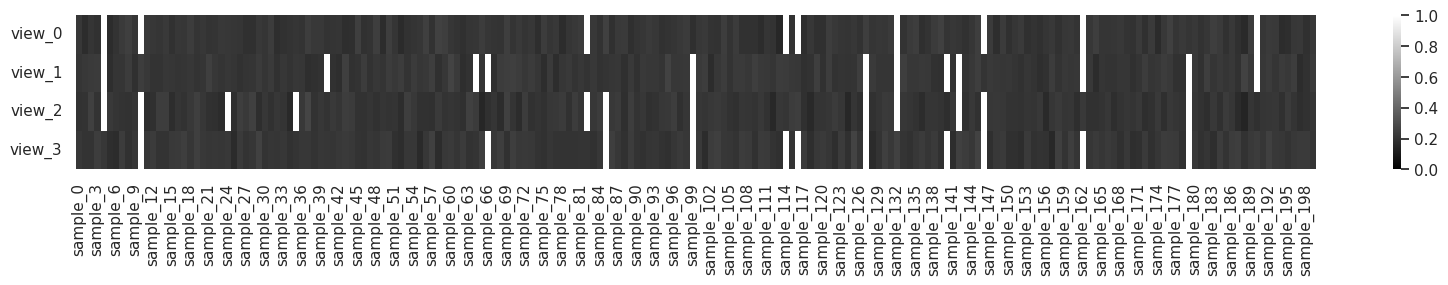

<Axes: >

In [12]:
muvi.pl.missingness_overview(model)

Now we can train our model via a (stochastic) variational inference algorithm.

In [13]:
model.fit(seed=seed, min_epochs=2000)

2025-11-21 19:50:10,411 - muvi.core.models - INFO - Using 5 particles in parallel.
2025-11-21 19:50:10,413 - muvi.core.models - INFO - Preparing model and guide...
2025-11-21 19:50:10,482 - muvi.core.models - INFO - Preparing optimizer...
2025-11-21 19:50:10,484 - muvi.core.models - INFO - Decaying learning rate over 10000 iterations.
2025-11-21 19:50:10,485 - muvi.core.models - INFO - Preparing SVI...
2025-11-21 19:50:10,486 - muvi.core.models - INFO - Preparing training data...
2025-11-21 19:50:10,494 - muvi.core.models - INFO - Using complete dataset.
2025-11-21 19:50:10,496 - muvi.core.models - INFO - Setting training seed to `0`.
2025-11-21 19:50:10,506 - muvi.core.models - INFO - Cleaning parameter store.
2025-11-21 19:50:10,508 - muvi.core.models - INFO - Starting training...


  0%|          | 0/10000 [00:00<?, ?it/s]

2025-11-21 19:50:10,853 - root - INFO - Guessed max_plate_nesting = 3


 22%|██▏       | 2203/10000 [03:19<11:44, 11.06it/s, ELBO=667]   

Relative improvement of -1.377e-05 < 1e-05 for 10 step(s) in a row, stopping early.
2025-11-21 19:53:29,614 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.


In [14]:
# overall RMSE
root_mean_squared_error(
    dg.y,
    np.concatenate([model.get_reconstructed()[vn] for vn in model.view_names], 1),
)

0.37958759932477015

Once the training converges, we may inspect the learned parameters and compare them to the true parameters.

<Axes: >

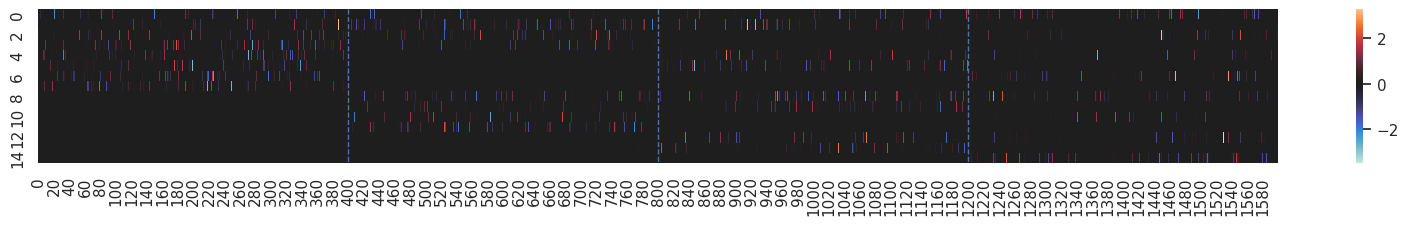

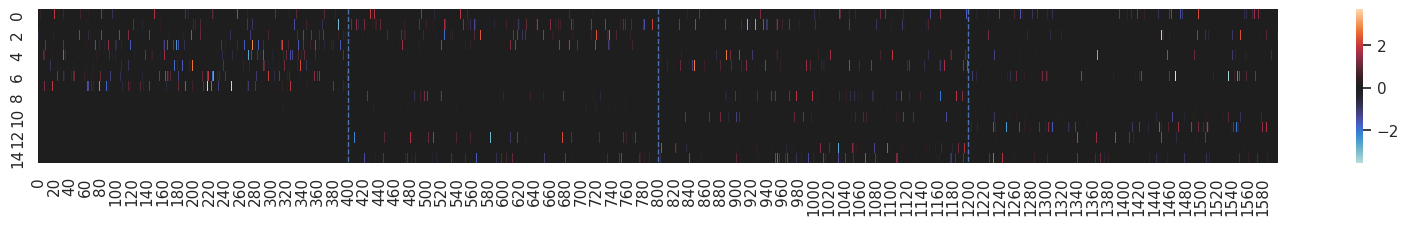

In [15]:
approx_ws = [model.get_factor_loadings()[vn] for vn in model.view_names]
approx_w = np.concatenate(approx_ws, axis=1)

muvi.pl.lined_heatmap(dg.w, vlines=vlines, center=0)
muvi.pl.lined_heatmap(approx_w, vlines=vlines, center=0)

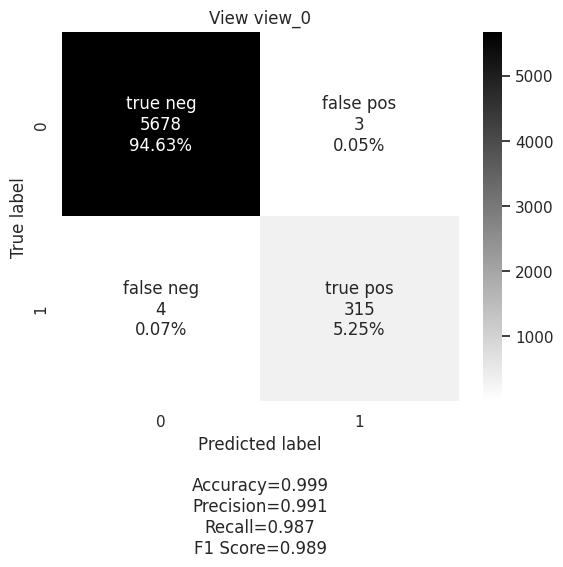

In [16]:
threshold = 0.1
# plot the confusion matrix between the true loadings activity and the learned loadings activity for the informed views
for m in informed_views:
    _ = muvi.pl.confusion_matrix(
        model, model.view_names[m], true_mask=dg.w_masks[m], threshold=threshold
    )
    plt.show()

Due to non-identifiability of FA models, it is sometimes necessary to permute the order of the factors match the true order. We do so by first computing the cosine similarities between the true factor loadings mask and the learned factor loading activations (based on a threshold). Then, we find the optimal permutation by matching each factor with its corresponding true factor index based on the largest cosine similarity.

<Axes: >

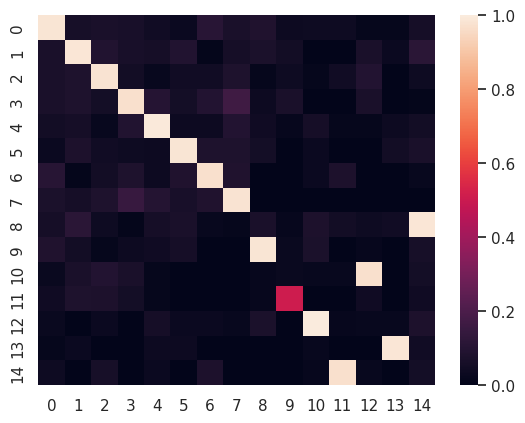

In [17]:
cos_sim = cosine_similarity(dg.w_mask, np.abs(approx_w) > threshold)
sns.heatmap(cos_sim, annot=False)

<Axes: >

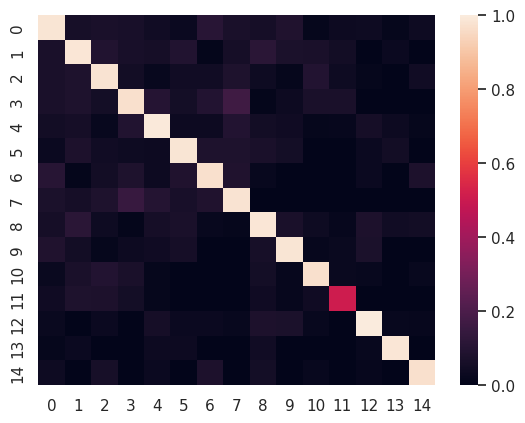

In [18]:
opt_order = muvi.tl.optim_perm(cos_sim).argmax(axis=0)
sns.heatmap(cos_sim[:, opt_order], annot=False)

Our model also infers the relationship across subsets of views by learning a set of `factor_scales` for each view. The lower the value of a factor scale $k$ in view $m$, the less significant this factor is for view $m$.

In [19]:
factor_scales = model._guide.get_factor_scale()
factor_scales = factor_scales / np.max(factor_scales, axis=1)[:, None]

<Axes: >

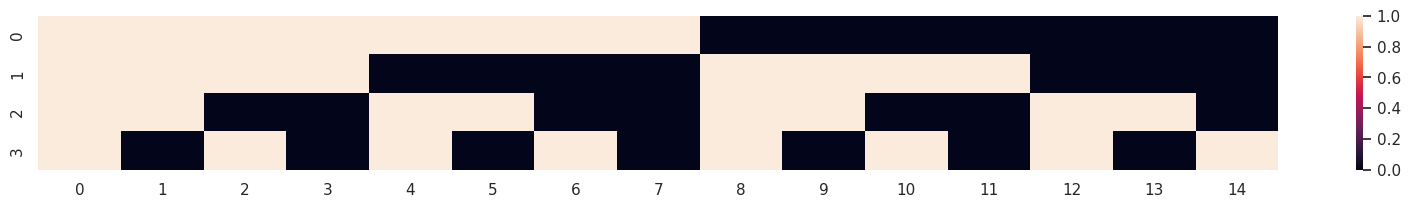

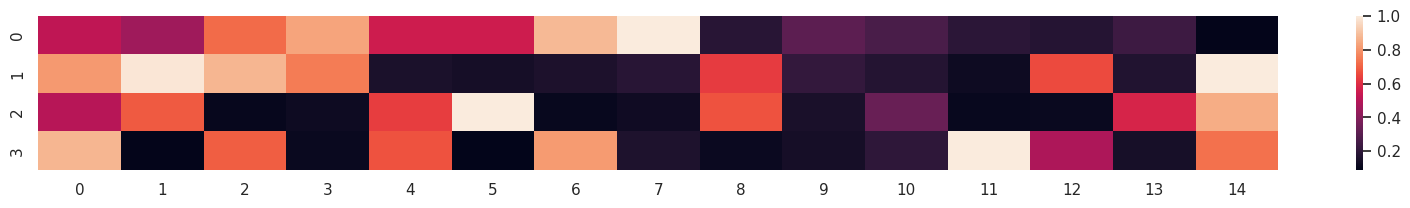

In [20]:
muvi.pl.lined_heatmap(dg.view_factor_mask)
muvi.pl.lined_heatmap(factor_scales)

We can also go one level deeper and inspect a single factors by extractin its factor loadings and plotting the sorted weights along with their corresponding state, one of true positive (TP), true negative (TN), false positive (FP) and false negative (FN). Ideally we would like to see true active loadings away from zero, i.e. true positives (TP), false negatives (FN), and true inactive loadings close to zero, i.e. false positives (FP), true negatives (TN)

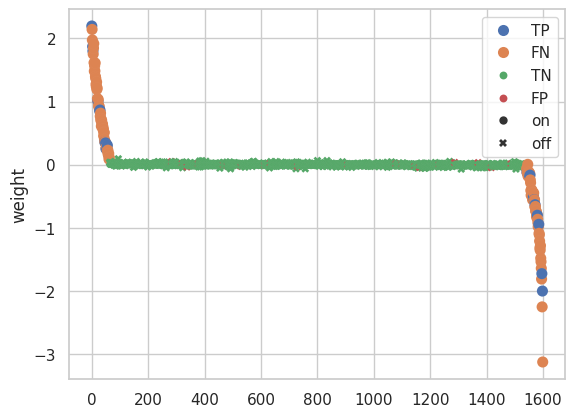

In [21]:
g, _ = muvi.pl.factor_activity(
    dg.w, approx_w[opt_order, :], dg.w_mask, dg.noisy_w_mask, factor_idx=0
)

Take a look at [this notebook](2_single-cell_rna-seq.ipynb) for a standard application of `MuVI` on a single-cell RNA-seq dataset of peripheral blood mononuclear cells (PBMCs) from lupus patients.